In [194]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uzairkhan45/breast-cancer-patients-mris")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1


In [195]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [196]:
walk_through(path)

There are 1 directories and 0 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1'.
There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI's'.
There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI's/validation'.
There are 0 directories and 40 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI's/validation/Healthy'.
There are 0 directories and 40 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI's/validation/Sick'.
There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI's/train'.
There are 0 directories and 700 images in '/r

In [197]:
import numpy as np
import torch
import torch.nn as nn

In [198]:
BASE_PATH = '/root/.cache/kagglehub/datasets/uzairkhan45/breast-cancer-patients-mris/versions/1/Breast Cancer Patients MRI\'s'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALIDATION_PATH = os.path.join(BASE_PATH, 'validation')

In [199]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [200]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

In [201]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),  # New augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Just resize and normalize for validation
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [202]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VALIDATION_PATH, transform=val_transforms)


In [203]:
len(train_dataset), len(val_dataset), train_dataset.classes

(1400, 80, ['Healthy', 'Sick'])

In [204]:
class_name = train_dataset.classes

class_name

['Healthy', 'Sick']

In [205]:
class_idx = train_dataset.class_to_idx

class_idx

{'Healthy': 0, 'Sick': 1}

In [206]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)

test_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bfe5e222990>,
 <torch.utils.data.dataloader.DataLoader at 0x7bfe5e2205d0>)

In [207]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model = model.to(device)

In [208]:
for layer in list(model.features)[-5:]:
    for param in layer.parameters():
        param.requires_grad = True

In [209]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(train_dataset.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.7, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)


In [210]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.1)

In [211]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [212]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0.0, 0.0
    total_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * X.size(0)  # Scale loss by batch size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step(loss)  # Step the scheduler if provided

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= total_samples  # Normalize by total dataset size
    train_acc /= total_samples  # Normalize accuracy

    return train_loss, train_acc

In [213]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:


    model.eval()


    test_loss, test_acc = 0, 0


    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)



            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [214]:
def train_and_validate(model,
                       train_loader,
                       val_loader,
                       criterion,
                       optimizer,
                       device,
                       num_epochs=50,
                       patience=5,
                       checkpoint_dir='./checkpoints'):
    """
    Train and validate the model with early stopping and checkpointing

    Args:
    - model: PyTorch model
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - criterion: Loss function
    - optimizer: Optimizer
    - device: Computing device (cuda/cpu)
    - num_epochs: Maximum number of training epochs
    - patience: Number of epochs with no improvement after which training will be stopped
    - checkpoint_dir: Directory to save model checkpoints

    Returns:
    - Dictionary containing training history
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Training history tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0, 0

        train_progress_bar = tqdm(train_loader,
                                  desc=f'Epoch {epoch+1}/{num_epochs}',
                                  unit='batch')

        for batch, (X, y) in enumerate(train_progress_bar):
            X, y = X.to(device), y.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute metrics
            train_loss += loss.item()
            train_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            train_acc += (train_pred == y).float().mean().item()

            # Update progress bar
            train_progress_bar.set_postfix({
                'Train Loss': loss.item(),
                'Train Acc': train_acc / (batch + 1)
            })

        # Average epoch metrics
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0

        with torch.inference_mode():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)

                outputs = model(X)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                val_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
                val_acc += (val_pred == y).float().mean().item()

        # Average validation metrics
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0

            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, os.path.join(checkpoint_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    return history

In [215]:
history = train_and_validate(
        model=model,
        train_loader=train_dataloader,
        val_loader=test_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=6,
        patience=3
    )


Epoch 1/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 1/6:
Train Loss: 0.6505, Train Acc: 0.6141
Val Loss: 0.5421, Val Acc: 0.6250


Epoch 2/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 2/6:
Train Loss: 0.5054, Train Acc: 0.7462
Val Loss: 0.4081, Val Acc: 0.8438


Epoch 3/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 3/6:
Train Loss: 0.3514, Train Acc: 0.8381
Val Loss: 0.2363, Val Acc: 0.9688


Epoch 4/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 4/6:
Train Loss: 0.2304, Train Acc: 0.9117
Val Loss: 0.4083, Val Acc: 0.8021


Epoch 5/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 5/6:
Train Loss: 0.1763, Train Acc: 0.9347
Val Loss: 0.0956, Val Acc: 1.0000


Epoch 6/6:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 6/6:
Train Loss: 0.1618, Train Acc: 0.9358
Val Loss: 0.0641, Val Acc: 1.0000


In [217]:
torch.save(model.state_dict(), 'model.pth')
torch.save(model, 'model_full.pth')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


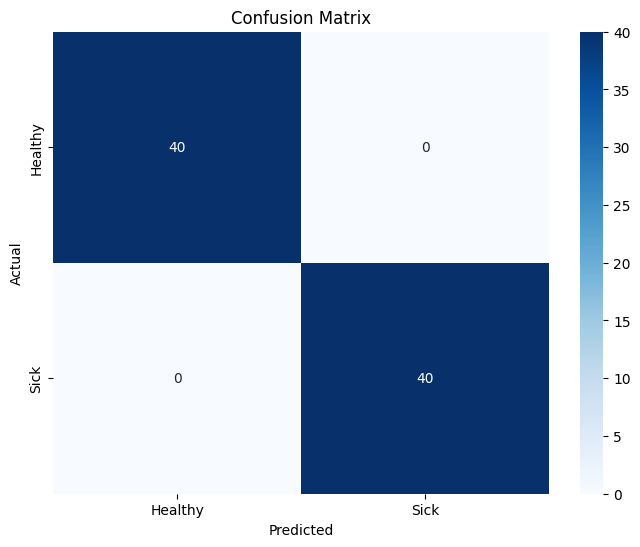

In [219]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = torch.argmax(model(X), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_dataloader, class_name)

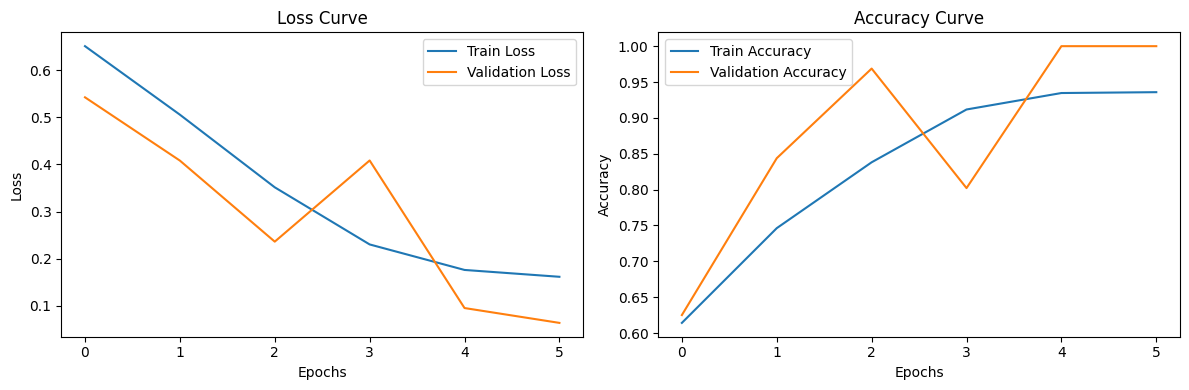

In [222]:
def plot_training_history(history):
    plt.figure(figsize=(12,4))

    # Loss Plot
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)